In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [2]:
df = pd.read_csv("data/spy_options.csv")
fridays = pd.date_range("2020-01-01", "2025-01-01", freq="WOM-3FRI").astype(str)
thursdays = pd.date_range("2020-01-01", "2025-01-01", freq="WOM-3THU").astype(str)
regulars = list(fridays) + list(thursdays)

df = df[df.expiration_date.isin(regulars)]
df['mid_price'] = (df.ask_price + df.bid_price) * 0.5
df = df[df.implied_volatility != 0]
df = df[df.ask_price != 0]
df = df[df.mid_price != 0]

In [4]:
df.rate

104     0.008000
106     0.008000
114     0.008000
118     0.008000
120     0.008000
          ...   
8170    0.188222
8171    0.188222
8172    0.188222
8173    0.188222
8174    0.188222
Name: rate, Length: 4100, dtype: float64

In [5]:
df.days_to_expiry

104       3
106       3
114       3
118       3
120       3
       ... 
8170    794
8171    794
8172    794
8173    794
8174    794
Name: days_to_expiry, Length: 4100, dtype: int64

### Fix Expiration

In [19]:
df.days_to_expiry.unique()

array([  3,  31,  59,  94, 122, 150, 185, 213, 304, 395, 430, 486, 577,
       668, 759, 794])

In [20]:
df = df[df.days_to_expiry == 94]

### Vary Strikes

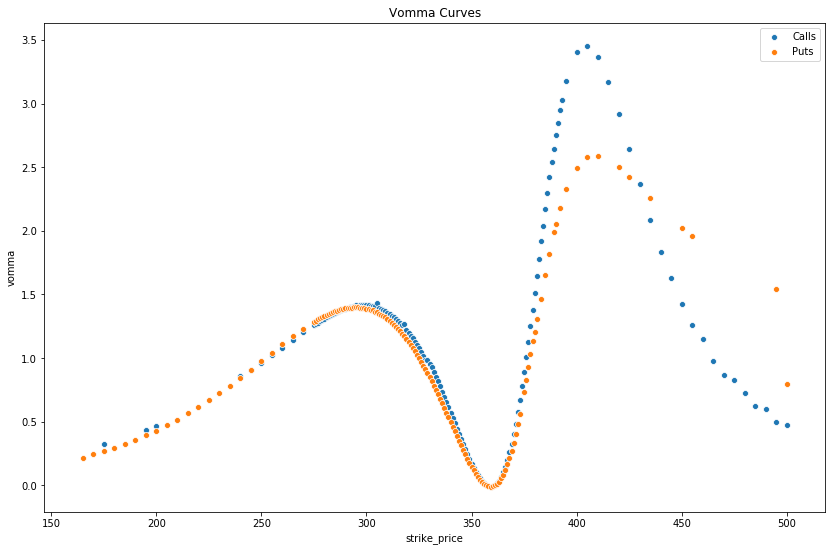

In [25]:
plt.figure(figsize=(14, 9))

c = df[df.option_type == "C"]
p = df[df.option_type == "P"]

sns.scatterplot(c.strike_price, c.vomma, label="Calls")
sns.scatterplot(p.strike_price, p.vomma, label="Puts")

plt.title("Vomma Curves")

plt.show()

### Vary Strikes

In [26]:
from scipy.stats import norm

greek_cols = [
	'delta',
	'gamma',
	'theta',
	'vega',
	'rho',
	'vanna',
	'vomma',
	'charm',
	'veta',
	'speed',
	'zomma',
	'color',
	'ultima'
]

def calculate_greeks(options):

	if len(options) == 0:
		return options

	o = options.copy()
	m = o.option_type.map({"C" : 1, "P" : -1}).values

	tau = o.days_to_expiry.values / 365
	rtau = np.sqrt(tau)
	iv = o.implied_volatility.values / 100
	S = o.stock_price.values
	K = o.strike_price.values
	q = o.dividend_yield.values / 100
	r = o.rate.values / 100

	###################################################################################################

	eqt = np.exp(-q * tau)
	kert = K * np.exp(-r * tau)

	d1 = np.log(S / K)
	d1 += (r - q + 0.5 * (iv ** 2)) * tau
	d1 /= iv * rtau
	d2 = d1 - iv * rtau

	npd1 = norm.pdf(d1)
	ncd1 = norm.cdf(m * d1)
	ncd2 = norm.cdf(m * d2)

	###################################################################################################

	delta = m * eqt * ncd1

	gamma = np.exp(q - r) * npd1
	gamma /= (S * iv * rtau)

	vega = S * eqt * npd1 * rtau	
	vega /= 100

	rho = m * tau * kert * ncd2
	rho /= 100

	theta = (S * norm.pdf(m * d1) * iv)
	theta *= -eqt / (2 * rtau)
	theta -= m * r * kert * ncd2
	theta += m * q * S * eqt * ncd1
	theta /= 365

	###################################################################################################

	vanna = (vega / S)
	vanna *= (1 - d1 / (iv * rtau))

	vomma = (vega / iv) * (d1 * d2)

	charm = 2 * (r - q) * tau - d2 * iv * rtau
	charm /= 2 * tau * iv * rtau
	charm *= eqt * npd1
	charm = m * q * eqt * ncd1 - charm
	charm /= 365

	veta = q.copy()
	veta += ((r - q) * d1) / (iv * rtau)
	veta -= (1 + d1 * d2) / (2 * tau)
	veta *= -S * eqt * npd1 * rtau
	veta /= 365 * 100

	speed = 1
	speed += d1 / (iv * rtau)
	speed *= -gamma / S

	zomma = (d1 * d2 - 1) / iv
	zomma *= gamma

	color = 2 * (r - q) * tau
	color -= d2 * iv * rtau
	color *= d1 / (iv * rtau)
	color += 2 * q * tau + 1
	color *= -eqt * npd1 / (2 * S * tau * iv * rtau)
	color /= 365

	ultima = d1 * d2 * (1 - d1 * d2) + d1 * d1 + d2 * d2
	ultima *= -vega / (iv * iv)

	###################################################################################################

	options['delta'] = delta
	options['gamma'] = gamma
	options['theta'] = theta
	options['vega'] = vega
	options['rho'] = rho

	options['vanna'] = vanna
	options['vomma'] = vomma
	options['charm'] = charm
	options['veta'] = veta
	options['speed'] = speed
	options['zomma'] = zomma
	options['color'] = color
	options['ultima'] = ultima

	###################################################################################################

	options.loc[:, greek_cols] = options[greek_cols].replace([-np.inf, np.inf], np.nan)
	options.loc[:, greek_cols] = options[greek_cols].round(6).fillna(0)
	options = options.sort_values(["date_current", "option_type"], ascending=True)

	return options

In [51]:
items = {}
for i in range(1, 10):
    
    tmp = df.copy()
    tmp['implied_volatility'] = tmp.implied_volatility + i * 10
    tmp = calculate_greeks(tmp)
    tmp = tmp[tmp.option_type == "C"]
    items[i] = tmp

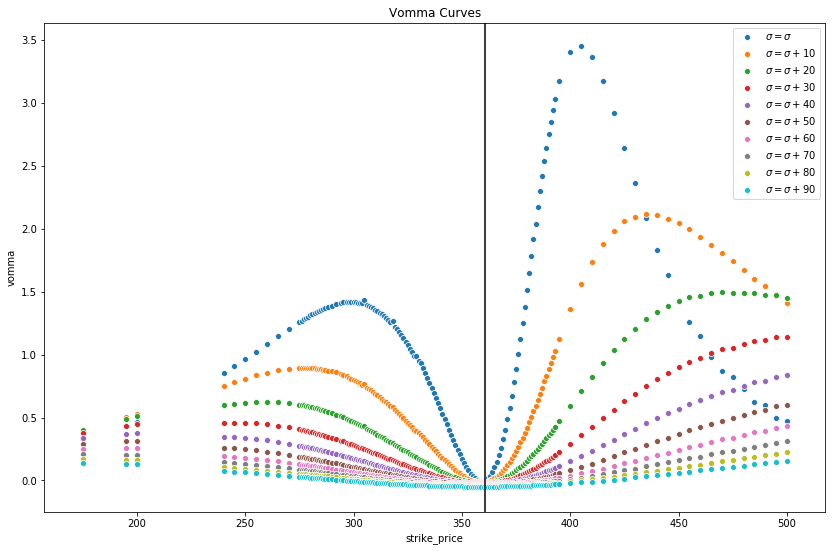

In [52]:
plt.figure(figsize=(14, 9))

c = df[df.option_type == "C"]
p = df[df.option_type == "P"]

sns.scatterplot(c.strike_price, c.vomma, label="$\sigma=\sigma$")
for i in items:
    sns.scatterplot(items[i].strike_price, items[i].vomma, label=f"$\sigma=\sigma+{i*10}%$")
plt.axvline(x=df.stock_price.values[0], color="black")
plt.title("Vomma Curves")
plt.savefig("plots/vomma_curves.png")
plt.show()

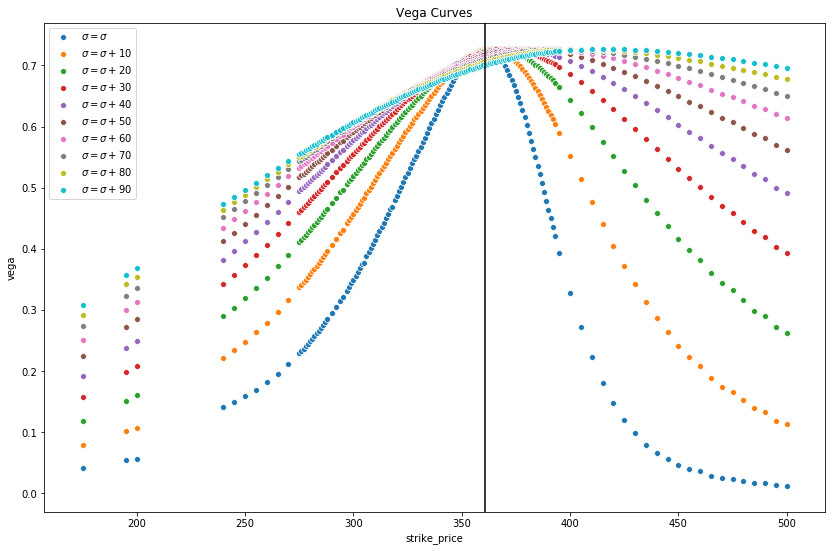

In [53]:
plt.figure(figsize=(14, 9))

c = df[df.option_type == "C"]
p = df[df.option_type == "P"]

sns.scatterplot(c.strike_price, c.vega, label="$\sigma=\sigma$")
for i in items:
    sns.scatterplot(items[i].strike_price, items[i].vega, label=f"$\sigma=\sigma+{i*10}%$")
plt.axvline(x=df.stock_price.values[0], color="black")
plt.title("Vega Curves")
plt.savefig("plots/vega_curves.png")
plt.show()

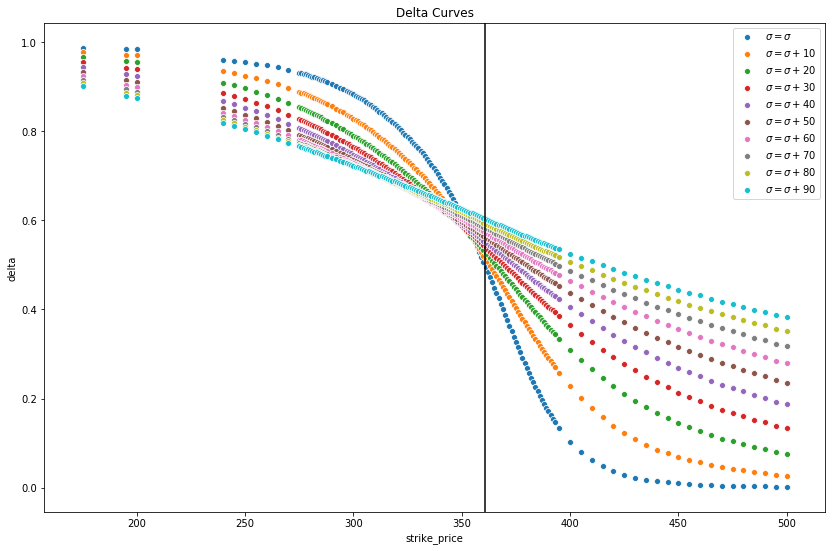

In [54]:
plt.figure(figsize=(14, 9))

c = df[df.option_type == "C"]
p = df[df.option_type == "P"]

sns.scatterplot(c.strike_price, c.delta, label="$\sigma=\sigma$")
for i in items:
    sns.scatterplot(items[i].strike_price, items[i].delta, label=f"$\sigma=\sigma+{i*10}%$")
plt.axvline(x=df.stock_price.values[0], color="black")
plt.title("Delta Curves")
plt.savefig("plots/delta_curves.png")
plt.show()

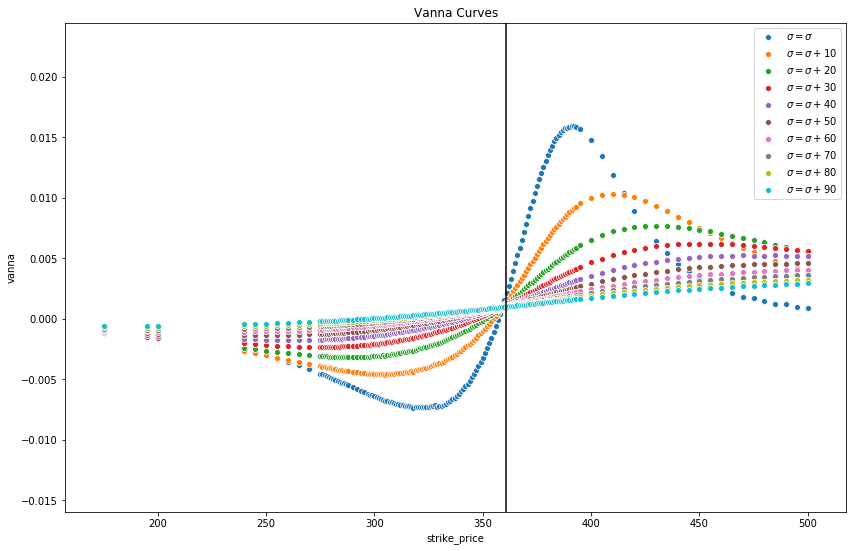

In [58]:
plt.figure(figsize=(14, 9))

c = df[df.option_type == "C"]
p = df[df.option_type == "P"]

sns.scatterplot(c.strike_price, c.vanna, label="$\sigma=\sigma$")
for i in items:
    sns.scatterplot(items[i].strike_price, items[i].vanna, label=f"$\sigma=\sigma+{i*10}%$")
plt.axvline(x=df.stock_price.values[0], color="black")
plt.title("Vanna Curves")
plt.savefig("plots/vanna_curves.png")
plt.show()